<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/synthetic_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [2]:
# Choose settings for the parameters part
estimate_parameters=False
name_parameters='params_dict'





## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1349, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1349 (delta 42), reused 33 (delta 18), pack-reused 1273
Receiving objects: 100% (1349/1349), 62.51 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (863/863), done.
Updating files: 100% (64/64), done.
Mounted at /content/drive


## Prepare Data

In [3]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')


In [4]:
fb=filter_first_h(fb,100)

gb=filter_first_h(gb,100)

rd=filter_first_h(rd,100)

vo=filter_first_h(vo,100)

In [5]:
names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

## Search parameters

In [6]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)

## Simulate synthetic data

In [11]:
n = 10
time_intervals = np.arange(0, 1, 0.01)

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data_M2(df, parameters, num_threads=n, activate_tqdm=False)
    globals()[f"{social}s_M2"] = simulated_t
    globals()[f"{social}o_M2"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M2 = pd.concat(all_dfs, ignore_index=True)

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)


,Time Grid Value,Share,Share_cc,post_id,Platform,Style
0,0.00,0.000000,0.000000,6166899,gb,Simulated
1,0.01,0.076923,0.000000,6166899,gb,Simulated
2,0.02,0.169231,0.030769,6166899,gb,Simulated
3,0.03,0.238462,0.069231,6166899,gb,Simulated
4,0.04,0.261538,0.076923,6166899,gb,Simulated
...,...,...,...,...,...,...
7995,0.95,1.000000,0.413043,4031693.0,vo,Observed
7996,0.96,1.000000,0.413043,4031693.0,vo,Observed
7997,0.97,1.000000,0.413043,4031693.0,vo,Observed
7998,0.98,1.000000,0.413043,4031693.0,vo,Observed


# Signals

## Dynamic

### Interaction Model - M2

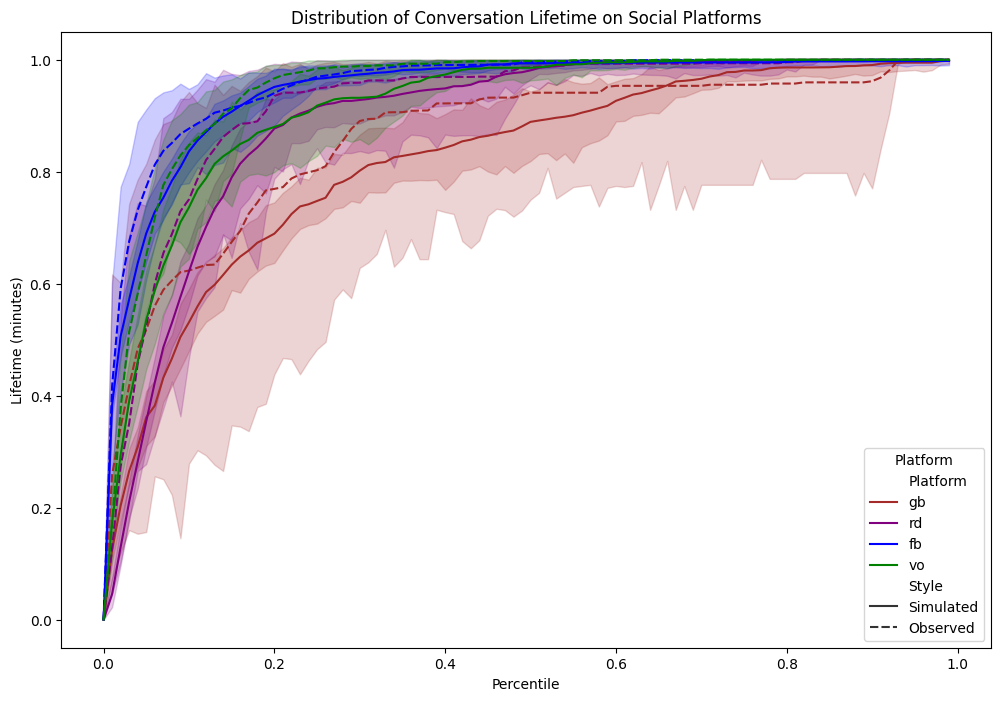

Platform
fb    0.003492
gb    0.047149
rd    0.014866
vo    0.006739
dtype: float64


In [17]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M2.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M2, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M2[df_all_M2['Style'] == 'Simulated']
df_line2 = df_all_M2[df_all_M2['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))
print(mse_per_platform_M2)

### Simple Model - M1

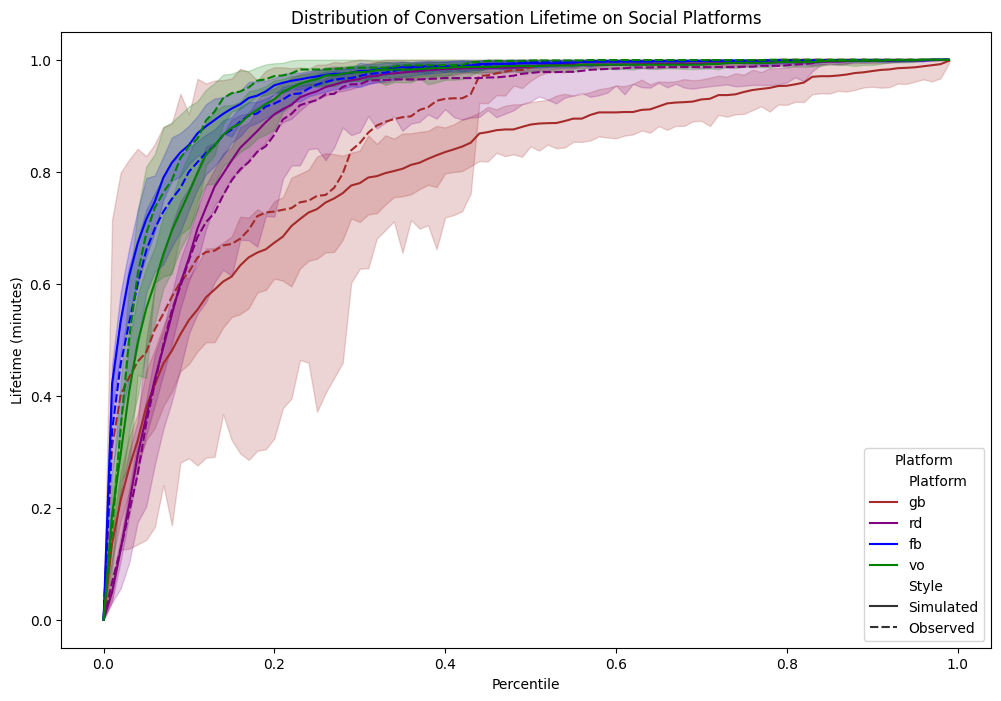

Platform
fb    0.001882
gb    0.046176
rd    0.005290
vo    0.004079
dtype: float64


In [19]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M1.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M1[df_all_M1['Style'] == 'Simulated']
df_line2 = df_all_M1[df_all_M1['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))
print(mse_per_platform_M1)

### Comparison Dyanamics Loss

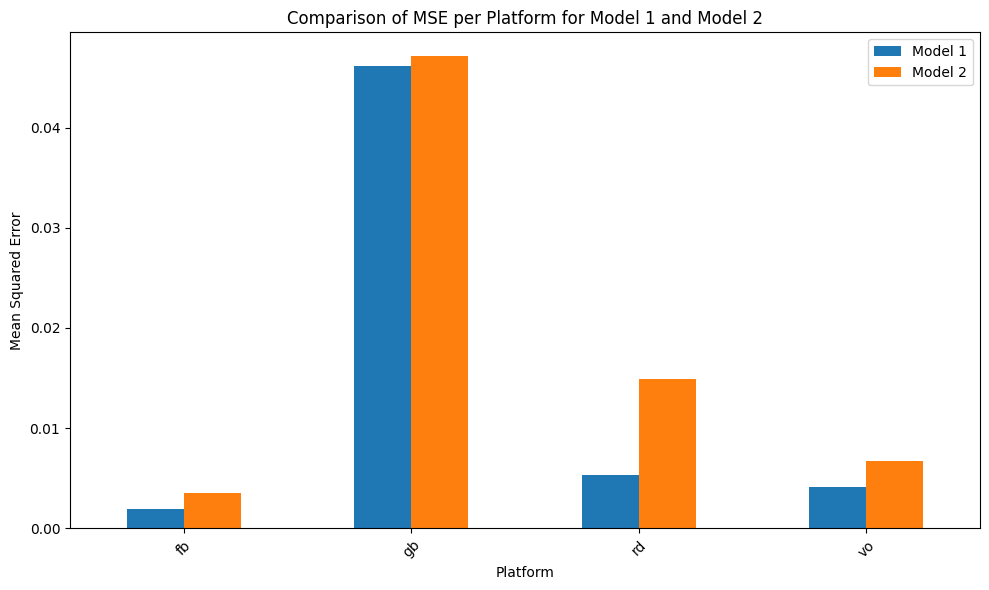

In [24]:
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

mse_df.plot(kind='bar', x='Platform', ax=ax)

plt.title('Comparison of MSE per Platform for Model 1 and Model 2')
plt.xlabel('Platform')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend(['Model 1', 'Model 2'])
plt.tight_layout()

plt.show()

## Conversation

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo_M1,  voo_M1,fbo_M1,gbo_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 27.07it/s]


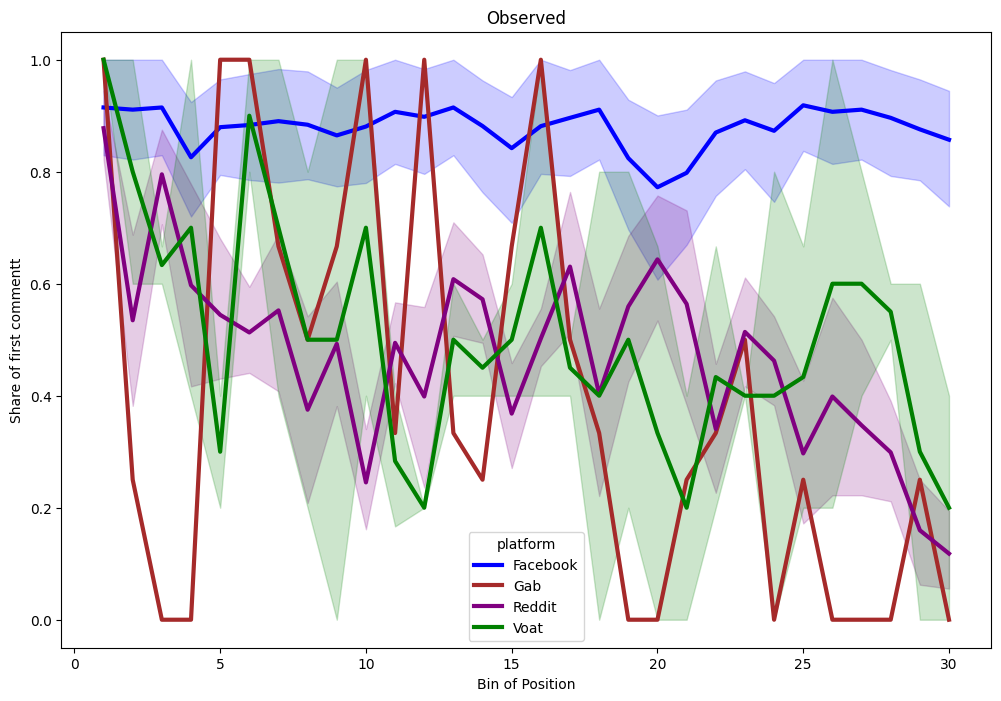

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue','Gab': 'brown'}#,'YouTube':'red'}  # Custom palette with specified colors
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M1

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M1['platform'] = 'Reddit'
vos_M1['platform'] = 'Voat'
fbs_M1['platform'] = 'Facebook'
gbs_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M1,  vos_M1,fbs_M1,gbs_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()



100%|██████████| 4/4 [00:00<00:00, 105.71it/s]


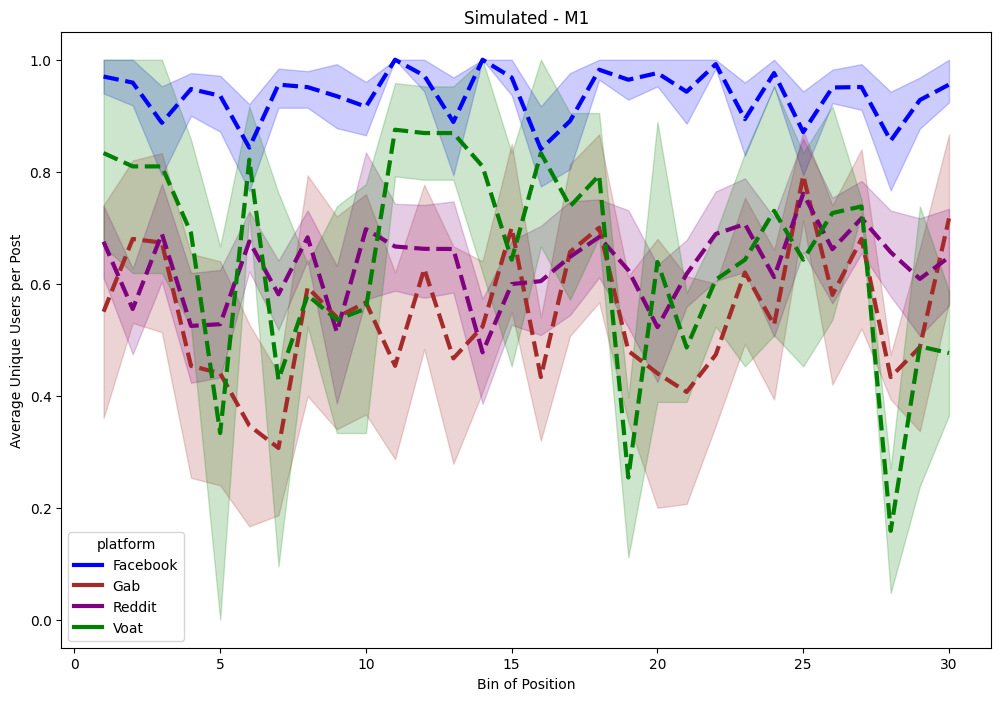

In [41]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M1')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M2

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M2['platform'] = 'Reddit'
vos_M2['platform'] = 'Voat'
fbs_M2['platform'] = 'Facebook'
gbs_M2['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M2,  vos_M2,fbs_M2,gbs_M2]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M2 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 58.87it/s]


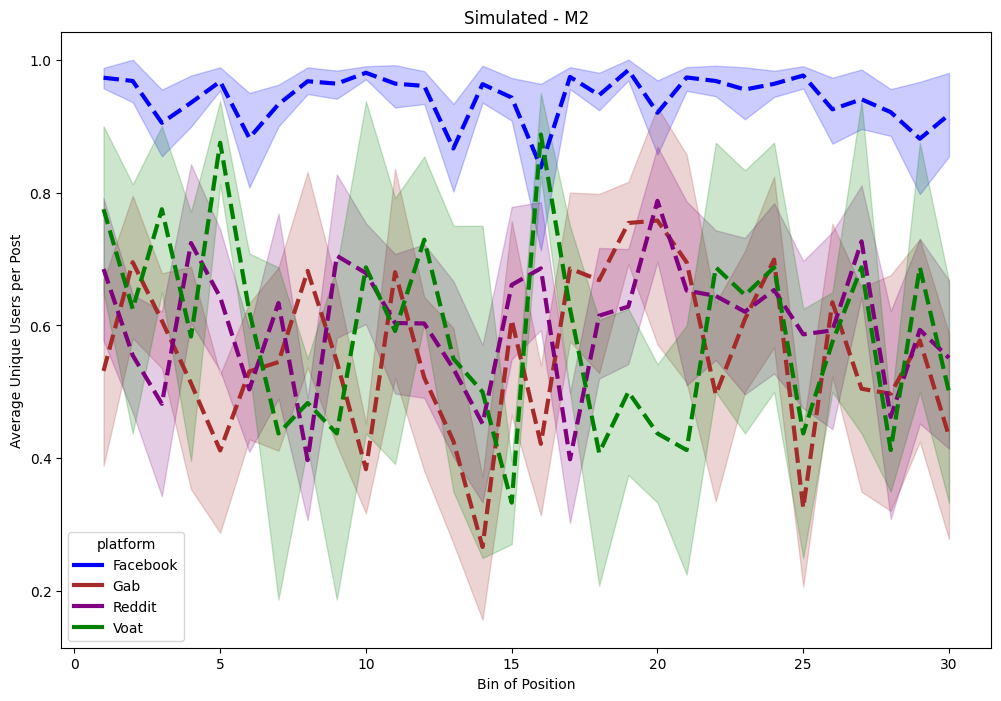

In [43]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M2,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M2')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


##### Loss comparison

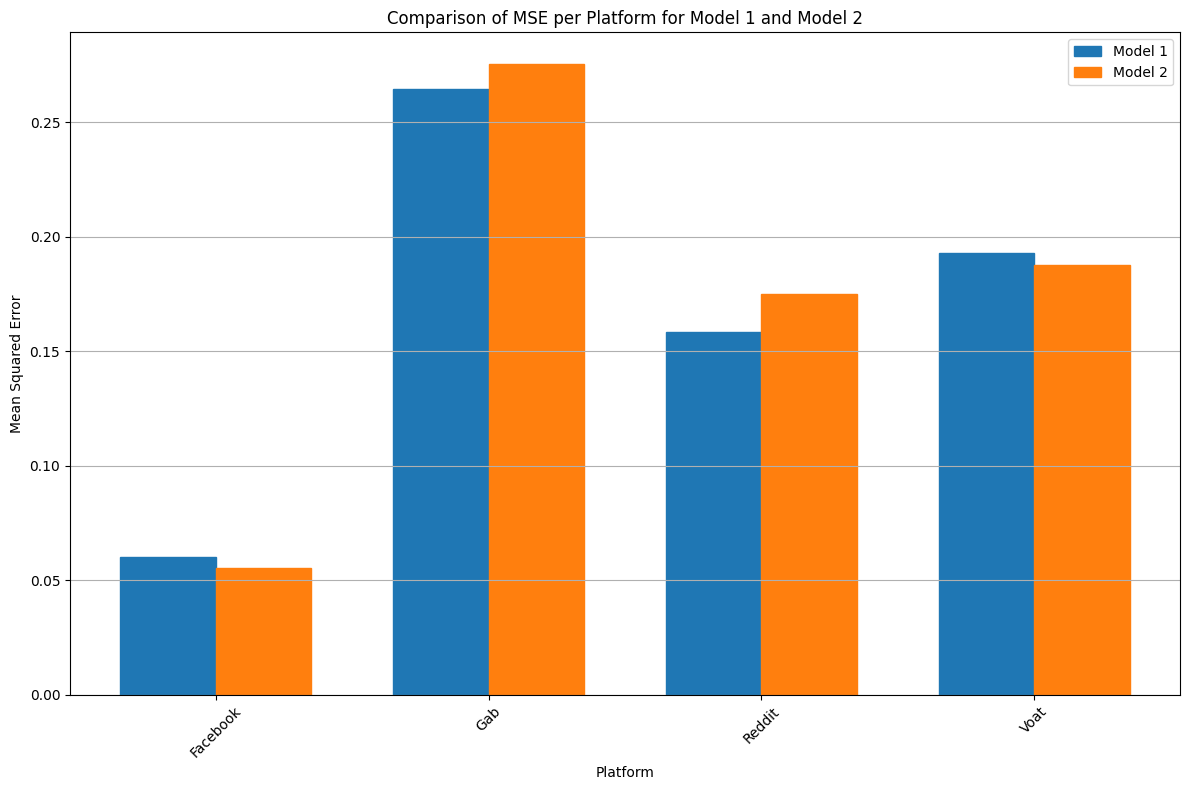

In [44]:


# Calculate MSE for each platform for Model 1
df_line1_M1 = agg_activity_sim_M1
df_line2 = agg_activity_obs

df_line1_M1 = df_line1_M1.set_index(['bin_of_position', 'platform'])
df_line2 = df_line2.set_index(['bin_of_position', 'platform'])

df_merged_M1 = df_line1_M1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged_M1.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Calculate MSE for each platform for Model 2
df_line1_M2 = agg_activity_sim_M2  # Assuming you have a similar DataFrame for Model 2
df_line1_M2 = df_line1_M2.set_index(['bin_of_position', 'platform'])

df_merged_M2 = df_line1_M2.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged_M2.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Combine MSE data into a single DataFrame for plotting
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

# Plotting the comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and edgecolors
colors = ['#1f77b4', '#ff7f0e']
edgecolors = ['#1f77b4', '#ff7f0e']

# Plot bars with custom colors and borders
bar_width = 0.35
index = np.arange(len(mse_df))

bar1 = ax.bar(index, mse_df['M1'], bar_width, color=colors[0], edgecolor=edgecolors[0], label='Model 1')
bar2 = ax.bar(index + bar_width, mse_df['M2'], bar_width, color=colors[1], edgecolor=edgecolors[1], label='Model 2')

# Add labels, title, and legend
ax.set_xlabel('Platform')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of MSE per Platform for Model 1 and Model 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mse_df['platform'], rotation=45)
ax.legend()

# Add a grid for better readability
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


## Lifetime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rds=rds.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbs=fbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
vos=vos.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbs=gbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rds.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = vos.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])

# Aggiungere le linee tratteggiate
for i in range(len(combined_data['source'].unique())):
    plt.gca().lines[6*i].set_linestyle('--')
    plt.gca().lines[6*i+1].set_linestyle('--')

plt.title('Simulated')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1, 0.6)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rdo=rdo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbo=fbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
voo=voo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbo=gbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rdo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = voo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green','red', 'blue'])
plt.title('Observed')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1,0.6)
plt.show()


## Number of comments for stymulus

In [18]:


def estimate_stimulus_reply(social):
    # Convert 'created_at' to datetime
    social['created_at'] = pd.to_datetime(social['created_at'])

    # Sort the data by 'post_id' and 'created_at'
    social = social.sort_values(by=['post_id', 'created_at'])

    # Assign a sequential index to each comment within each 'post_id' group
    social['indice_commento'] = social.groupby('post_id').cumcount()

    # Select columns of interest
    df = social[['indice_commento', 'user_id', 'post_id',
                 'sequential_number_of_comment_by_user_in_thread',
                 'number_of_comments_by_user_in_thread',
                 'number_of_comments']].copy()

    # Calculate the distance between comments
    df['distanza_tra_commenti'] = df.groupby(['user_id', 'post_id'])['indice_commento'].diff()
    df['distanza_tra_commenti_relativa'] = df['indice_commento'] / df['number_of_comments']

    # Filter for specific values
    df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread'] == 3) &
                     (df['number_of_comments_by_user_in_thread'] != df['sequential_number_of_comment_by_user_in_thread'])]

    # Extract the filtered data
    data_to_fit = df_filtered['distanza_tra_commenti_relativa']

    # Check for finite values
    data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

    # Fit the Beta distribution to the data
    a, b, loc, scale = beta.fit(data_to_fit)

    return a, b, loc, scale

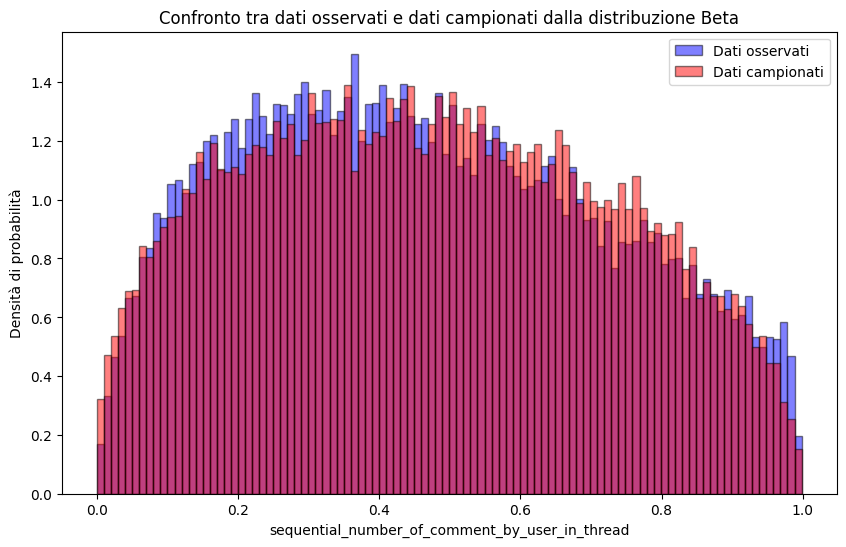

In [48]:
social=fb
#social['post_id']=social['root_submission']
#social['user_id']=social['user']
# Converti 'created_at' in formato datetime
social['created_at'] = pd.to_datetime(social['created_at'])

# Ordina i dati per 'post_id' e 'created_at'
social = social.sort_values(by=['post_id', 'created_at'])

# Assegna un indice sequenziale a ogni commento all'interno di ciascun gruppo di 'post_id'
social['indice_commento'] = social.groupby('post_id').cumcount()

# Seleziona le colonne di interesse
df = social[['indice_commento', 'user_id', 'post_id', 'sequential_number_of_comment_by_user_in_thread','number_of_comments_by_user_in_thread', 'number_of_comments']].copy()

df['distanza_tra_commenti'] = df.groupby(['user_id','post_id',])['indice_commento'].diff()
df['distanza_tra_commenti_relativa'] =df['indice_commento']/df['number_of_comments']
# Filtro per il valore 2

df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread']==3) & ( df['number_of_comments_by_user_in_thread'] !=df['sequential_number_of_comment_by_user_in_thread'] )]


# Esempio di DataFrame filtrato (df_filtered) con i dati di 'distanza_tra_commenti'
# df_filtered = pd.DataFrame({'distanza_tra_commenti': ...})

# Estrazione dei dati filtrati
data_to_fit = df_filtered['distanza_tra_commenti_relativa']

# Verifica di valori finiti
data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

# Fit della distribuzione Beta ai dati
a, b, loc, scale = beta.fit(data_to_fit)

# Campionamento dalla distribuzione Beta con i parametri ottenuti
sampled_data = beta.rvs(a, b, loc, scale, size=len(data_to_fit))

# Creazione dei bins comuni
num_bins = 100
bins = np.histogram_bin_edges(data_to_fit, bins=num_bins)

# Plot dei dati osservati e dei dati campionati
plt.figure(figsize=(10, 6))

# Istogramma dei dati osservati
plt.hist(data_to_fit, bins=bins, density=True, alpha=0.5, color='blue', edgecolor='black', label='Dati osservati')

# Istogramma dei dati campionati
plt.hist(sampled_data, bins=bins, density=True, alpha=0.5, color='red', edgecolor='black', label='Dati campionati')

plt.title('Confronto tra dati osservati e dati campionati dalla distribuzione Beta')
plt.xlabel('sequential_number_of_comment_by_user_in_thread')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()
